In [ ]:
using CausalityTools
include("../entropy.jl")
using Random
using BenchmarkTools

rng = MersenneTwister(145)

a = rand(rng, 0:10, 100)
b = rand(rng, 0:10, 100)

est = Kraskov(k=1)

print("Current method :")
foo = @btime TE(Int.(a .> 0), Int.(b .> 0))
println("The result is $foo.\n")


print("True transfer entropy :")
a = float.(a)
b = float.(b)
foo2 = @btime transferentropy(a, b, est)
println("The result is $foo2.\n")

print("CCM :")
foo3 = @btime crossmap(a, b, 2, 1)
println("The result is $foo3.\n")

In [ ]:
import PyPlot as plt

rng = MersenneTwister(145)

a = rand(rng, 0:10, 100)
b = rand(rng, 0:10, 100)

a = float.(a)
b = float.(b)

Ls = [10:5:50; 60:10:100]

@btime begin
    test = [crossmap(a[1:L], b[1:L], 2, 1) for L in Ls]
    test2 = [crossmap(b[1:L], a[1:L], 2, 1) for L in Ls]
end

plt.figure()
plt.plot(Ls, test, "b-", label="a to b")
plt.plot(Ls, test2, "r-", label="b to a")
plt.legend()
show(plt.gcf())

In [ ]:
using CausalityTools

s_measure()

In [14]:
using CausalityTools

# A two-dimensional Ulam lattice map
sys = ulam(2)

# Sample 1000 points after discarding 5000 transients
orbit = trajectory(sys, 1000, Ttr = 5000)
x, y = orbit[:, 1], orbit[:, 2]

# 4-dimensional embedding for `x`, 5-dimensional embedding for `y`
s_measure(x, y, dx = 4, τx = 3, dy = 5, τy = 1)

MethodError: MethodError: no method matching s_measure(::Vector{Float64}, ::Vector{Float64}; dx=4, τx=3, my=5, τy=1)
Closest candidates are:
  s_measure(::AbstractVector{T}, ::AbstractVector{T}; K, dx, dy, τx, τy, metric, tree_metric) where T at ~/.julia/packages/CausalityTools/Zxxnz/src/SMeasure/smeasure.jl:140 got unsupported keyword argument "my"
  s_measure(!Matched::DelayEmbeddings.AbstractDataset{D}, ::AbstractVector{T}; K, dy, τy, metric, tree_metric) where {D, T} at ~/.julia/packages/CausalityTools/Zxxnz/src/SMeasure/smeasure.jl:155 got unsupported keyword arguments "dx", "τx", "my"
  s_measure(::AbstractVector{T}, !Matched::DelayEmbeddings.AbstractDataset{D}; K, dx, τx, metric, tree_metric) where {D, T} at ~/.julia/packages/CausalityTools/Zxxnz/src/SMeasure/smeasure.jl:163 got unsupported keyword arguments "my", "τy"

In [23]:
using DelayEmbeddings

a = collect(1:100)
p = embed(a, 2, 5)

2-dimensional Dataset{Int64} with 95 points
  1    6
  2    7
  3    8
  4    9
  5   10
  6   11
  7   12
  8   13
  9   14
 10   15
  ⋮  
 87   92
 88   93
 89   94
 90   95
 91   96
 92   97
 93   98
 94   99
 95  100

In [26]:
using Neighborhood

a = [0, 1.2, 0.1, 0.8]
b = [0, 0, 1.8, 0.8]


X = embed(a, 2, 1)
Y = embed(b, 2, 1)

treeX = searchstructure(KDTree, X, Euclidean())
treeY = searchstructure(KDTree, Y, Euclidean())
neighborhoodtype, theiler = NeighborNumber(1), Theiler(0)
idxs_X = bulkisearch(treeX, X, neighborhoodtype, theiler)
idxs_Y = bulkisearch(treeY, Y, neighborhoodtype, theiler)

print(idxs_Y)

LoadError: UndefVarError: embed not defined

In [3]:
using CausalityTools
using BenchmarkTools

include("../Utils/entropy.jl")

x = rand(0:10, 50)
y = rand(0:10, 50)

@btime s_measure(float(x), float(y), K=3, dx=5, dy=5, τx=1, τy=1)

@btime TE(Int.(x .> 0), Int.(y .> 0))

  39.459 μs (689 allocations: 48.64 KiB)
  1.271 μs (11 allocations: 1.23 KiB)


NaN

In [11]:
using HypothesisTests

x = rand(0:10, 50)
y = rand(0:10, 50)

@btime jdd(OneSampleTTest, x, y, B=10, D=2, τ=1)

  58.584 μs (65 allocations: 222.17 KiB)


One sample t-test
-----------------
Population details:
    parameter of interest:   Mean
    value under h_0:         0.0
    point estimate:          0.275
    95% confidence interval: (-0.0137, 0.5637)

Test summary:
    outcome with 95% confidence: fail to reject h_0
    two-sided p-value:           0.0596

Details:
    number of observations:   10
    t-statistic:              2.1547879226714413
    degrees of freedom:       9
    empirical standard error: 0.12762276839711598


In [36]:
source = collect(1:5)
target = collect(11:15)

D = 2
B = 10
τs = 1

@btime Ex = DelayEmbeddings.embed(source, D, τs)
Ey = DelayEmbeddings.embed(target, D, τs)
Mx = DelayEmbeddings.Matrix(Ex)
My = DelayEmbeddings.Matrix(Ey)

  890.733 ns (7 allocations: 304 bytes)


4×2 Matrix{Int64}:
 11  12
 12  13
 13  14
 14  15

In [23]:
import DelayEmbeddings

source = collect(1:5)
target = collect(11:15)

D = 2
B = 10
τ = 1

js = ([1 for i = 1:D]...,)
τs = (collect(0:-τ:-(D-1)*τ)...,)

Ex = DelayEmbeddings.genembed(source, τs, js)
Ey = DelayEmbeddings.genembed(target, τs, js)
Mx = DelayEmbeddings.Matrix(Ex)
My = DelayEmbeddings.Matrix(Ey)

4×2 Matrix{Int64}:
 12  11
 13  12
 14  13
 15  14

In [27]:
Matrix(Ex) 

4×2 Matrix{Int64}:
 2  1
 3  2
 4  3
 5  4

In [33]:
foo = [0 1; 2 0]
LinearIndices(foo[foo .> 0])

2-element LinearIndices{1, Tuple{Base.OneTo{Int64}}}:
 1
 2

In [24]:
My

4×2 Matrix{Int64}:
 12  11
 13  12
 14  13
 15  14

In [19]:
Mx

4×2 Matrix{Int64}:
 2  1
 3  2
 4  3
 5  4

In [21]:
using Distances

pairwise(Euclidean(), Mx, Mx, dims=1)

4×4 Matrix{Float64}:
 0.0      1.41421  2.82843  4.24264
 1.41421  0.0      1.41421  2.82843
 2.82843  1.41421  0.0      1.41421
 4.24264  2.82843  1.41421  0.0

In [23]:
Euclidean()([2,1], [3,2])

1.4142135623730951

In [35]:
using BenchmarkTools
using CausalityTools

include("../Utils/entropy.jl")

B = 10
d = 3
τ = 1
alpha = 0.001

K = 3
dx = 3
dy = 3
τx = 1
τy = 1

cuttoff = 0.5
cuttoff2 = 0.01

func1(x, y) = pvalue(jdd(OneSampleTTest, x, y, B=B, D=d, τ=τ, μ0=0.0), tail=:right) < alpha ? 1 : 0
func2(x, y) = TE(Int.(x .> 0), Int.(y .> 0)) > cuttoff ? 1 : 0
func3(x,y) = s_measure(float(x), float(y), K=K, dx=dx, dy=dy, τx=τx, τy=τy) > cuttoff2 ? 1 : 0

tot1 = 0
tot2 = 0
tot3 = 0
nans = 0
for i = 1:100
    x = rand(0:10, 30)
    y = rand(0:10, 30)

    tot1 += func1(x ,y)
    tot2 += func2(x ,y)
    tot3 += func3(x ,y)
end

println("jdd : $tot1")
println("TE : $tot2")
println("s measure : $tot3")

jdd : 5
TE : 0
s measure : 100


In [63]:
using BenchmarkTools
using CausalityTools

B = 10
d = 3
τ = 1
alpha = 0.001

cuttoff = 0.5
cuttoff2 = 0.01

func(x, y) = pvalue(jdd(OneSampleTTest, x, y, B=B, D=d, τ=τ, μ0=0.0), tail=:right) < alpha ? 1 : 0

tot = 0

for i = 1:1000
    x = rand(0:10, 1000)
    y = rand(0:10, 1000)

    tot += func(x ,y)
end

println("jdd : $tot")

jdd : 0


In [209]:
using BenchmarkTools
using CausalityTools
using StatsBase

function normalize(x)
    return (x .- mean(x))/std(x)
end


B = 10
d = 3
τ = 1
alpha = 0.001

Nsurr = 50
p_value_surr = Vector{Float64}(undef, Nsurr)

func(x, y) = pvalue(jdd(OneSampleTTest, x, y, B=B, D=d, τ=τ, μ0=0.0), tail=:right)

tot = 0
eviter = 0

for i = 1:1000
    x = rand(0:10, 100)
    y = rand(0:10, 100)

    p = func(x, y)

    if p < alpha

        s = surrogenerator(x, RandomShuffle())

        for i = 1:Nsurr
            p_value_surr[i] = func(s(), y)
            # p_value_surr[i] = func(rand(0:10, 100), y)
        end

        limit = quantile(p_value_surr, 0.01)/4
        limit2 = minimum()

        if p < limit
            tot += 1
            println("p : $p    limit: $limit     limit2: $(limit2)")

        else
            eviter += 1
        end

    end

    #= if p < alpha
        tot += 1
    end =#

end

println("jdd : $tot")
println("We removed : $eviter")

p : 0.00032785446214250144    limit: 0.0007147071949659619     limit2: 0.02716158683825249
p : 0.0005640059239774532    limit: 0.0007056421044315651     limit2: 0.025838711872565562
p : 0.0002734664819900032    limit: 0.00040544296586519663     limit2: 0.033272985497052265
p : 0.00047965514956183715    limit: 0.000534832540712606     limit2: 0.024908326774016862
jdd : 4
We removed : 5


In [211]:
println(quantile(p_value_surr, 0.01)/4)
println(quantile(p_value_surr, 0.05)/4)
confint(OneSampleTTest(p_value_surr), 0.0001)

0.000534832540712606
0.0008535608798262756


(0.015519488438222168, 0.05124801846058763)

In [186]:
x = 1:100
y = 101:200

p = func(x, y)

if p < alpha

    s = surrogenerator(x, RandomShuffle())

    for i = 1:Nsurr
        p_value_surr[i] = func(s(), y)
        # p_value_surr[i] = func(rand(0:10, 100), y)
    end

    limit = minimum(p_value_surr)/2 #quantile(p_value_surr, 0.05)

    println("p : $p    limit: $limit")

    if p < limit
        tot += 1
    end

end

p : 9.127474287418247e-19    limit: 0.05988142748262146


7

([1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 3.0, 3.0, 5.0, 2.0, 3.0, 2.0, 2.0, 3.0, 4.0, 1.0, 2.0, 3.0, 6.0, 4.0], [0.008610910984738948, 0.01670874568645315, 0.024806580388167347, 0.03290441508988155, 0.04100224979159575, 0.04910008449330995, 0.057197919195024156, 0.06529575389673835, 0.07339358859845255, 0.08149142330016675, 0.08958925800188094, 0.09768709270359514, 0.10578492740530936, 0.11388276210702356, 0.12198059680873775, 0.13007843151045195, 0.13817626621216617, 0.14627410091388038, 0.15437193561559456, 0.16246977031730878, 0.17056760501902296], (PyObject <matplotlib.patches.Rectangle object at 0x2b06e65c0>, PyObject <matplotlib.patches.Rectangle object at 0x2b06e4610>, PyObject <matplotlib.patches.Rectangle object at 0x2b05c96f0>, PyObject <matplotlib.patches.Rectangle object at 0x2b05ca8c0>, PyObject <matplotlib.patches.Rectangle object at 0x2b05c9c00>, PyObject <matplotlib.patches.Rectangle object at 0x2b05c8cd0>, PyObject <matplotlib.patches.Rectangle object at 0x2b05c92d0>, PyObject 

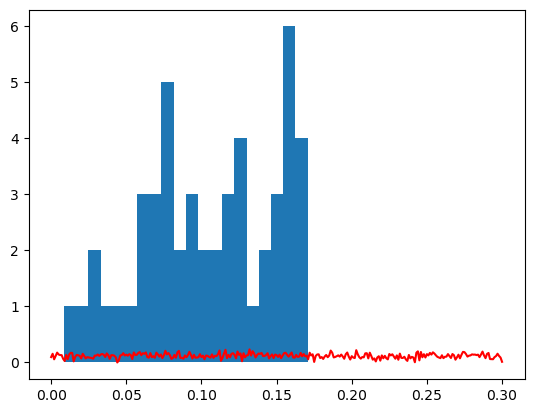

Normal{Float64}(μ=0.10464798000976253, σ=0.04431662600719932)

In [193]:
import PyPlot as plt
using Distributions

foo = fit_mle(Normal, p_value_surr)


show(plt.hist(p_value_surr, bins=20))
plt.plot(0:0.001:0.3, rand(foo, length(0:0.001:0.3)), "-r")
foo

In [180]:
float.(p_value_surr)

50-element Vector{Float64}:
 0.08895896762770654
 0.15376642740478572
 0.09974603267157996
 0.16296447686590748
 0.1415791128370667
 0.0823715570605691
 0.1651237983664177
 0.043597631186268894
 0.06934667087168953
 0.08404808453391846
 0.10838825964149638
 0.07977758680804285
 0.1642121901940383
 ⋮
 0.15802224095081452
 0.01912171857224068
 0.05627225017622281
 0.14280975208519017
 0.16939226640523722
 0.07245043771911297
 0.06504430831159581
 0.10907300458377739
 0.16828733381368038
 0.0759373863710036
 0.16144006667136968
 0.07613458798156238

In [176]:
d = Normal()
x = rand(d, 100)



100-element Vector{Float64}:
  0.05960113260616646
  0.5086185664432574
  1.3171255655621763
  0.669803941409575
 -0.7832187282838059
  0.47011587639402225
  0.5096273115410052
  0.7184981780011926
 -0.43850664593136063
 -2.0209077133500566
 -1.5739272342375747
 -0.3881130744563902
  0.29100716232952767
  ⋮
  0.9389135549033801
 -1.0355942318960945
  0.7547671178886021
  0.4191717431855258
 -1.1515016379163747
 -1.0099598651165378
  1.958103132817978
 -0.9281265450220242
  0.04096772832744455
 -1.4977583546530575
 -0.8509162508239447
 -0.9072917744552235

In [131]:
mean(p_value_surr) - std(p_value_surr)

0.004982735549558252

In [14]:
using CausalityTools

a = collect(1:30)
b = collect(51:80)

a = [[0 for i in 1:30]..., a...]
b = [[0 for i in 1:30]..., b...]

B = 10
d = 3
τ = 5
alpha = 0.001

func(x,y) = pvalue(jdd(OneSampleTTest, x, y, B=B, D=d, τ=τ, μ0=0.0), tail=:right)
func(a, b)

8.465778128597038e-6

In [82]:
func2(x, y) = TE(Int.(x .> 0), Int.(y .> 0))

nans = 0
for i = 1:100
    x = rand(0:10, 100)
    y = rand(0:10, 100)

    isnan(func2(x,y)) ? nans += 1 : nans += 0
end

nans

100

In [3]:
x = rand(0:10, 30)
y = rand(0:10, 30)

B = 10
d = 3
τ = 1
alpha = 0.001

func1(x, y) = pvalue(jdd(OneSampleTTest, x, y, B=B, D=d, τ=τ, μ0=0.0), tail=:right) < alpha ? 1 : 0
@btime func1(x,y)

LoadError: LoadError: UndefVarError: @btime not defined
in expression starting at In[3]:10

In [20]:
foo = zeros(3,3)
try
    a = minimum(foo[foo .> 0])
catch
    print("foo")
end

foo

In [67]:
est = VisitationFrequency(RectangularBinning(10))

n = 1000
# Source and target variables
s, t = rand(n), rand(n)


est = NaiveKernel(0.3)
@btime bbnue(s, t, est)

  338.373 ms (426459 allocations: 671.50 MiB)


(0.0, Int64[], Int64[], 1:1, 2:2, Int64[])

In [21]:
using CausalityTools

a = float([[0 for i = 1:24]..., 1, [0 for i = 1:75]...])
b = float([[0 for i = 1:36]..., 1, [0 for i = 1:63]...])

a = (a .- mean(a)) / std(a)
b = (b .- mean(b)) / std(b)

transferentropy(a, b, Kraskov(k=3))

NaN

In [49]:
using Dates

start_time = DateTime(2021, 10, 11, 13, 23, 12) 
end_time = DateTime(2021, 10, 28, 23, 29, 13) 
time_interval = Day(1)

println(floor(start_time, time_interval))
println(ceil(end_time, time_interval))

2021-10-11T00:00:00
2021-10-29T00:00:00


In [53]:
start_time = DateTime(2021, 10, 11, 13, 23, 12) 
end_time = DateTime(2021, 10, 28, 23, 29, 13) 
time_interval = Day(1)

function create_time_intervals(start_time::DateTime, end_time::DateTime, time_interval::Period)

    # Set beginning and end of interval by rounding
    start_time = floor(start_time, time_interval)
    end_time = ceil(end_time, time_interval)

    intervals = [start_time]
    
    if end_time - start_time > time_interval
        start = start_time
        while start + time_interval < end_time
            push!(intervals, start + time_interval)
            start += time_interval
        end
    end
            
    push!(intervals, end_time)
    
    return intervals


end

create_time_intervals(start_time, end_time, time_interval)

start_time

2021-10-11T13:23:12

In [42]:
Minute <: Period

true

In [5]:
using DataFrames
using Dates
include("../Utils/Helpers.jl")
using .Helpers

datafolder = "../../Data/Twitter/COP26_processed_lightweight/"
datafiles = [file for file in readdir(datafolder) if occursin(".json", file)]
frames = [load_json(datafolder * file) for file in datafiles]
data = vcat(frames...)

data = data[.~ismissing.(data."domain"), :]

to_datetime = x -> DateTime(split(x, '.')[1], "yyyy-mm-ddTHH:MM:SS")
data."created_at" = to_datetime.(data."created_at");

In [61]:
start_time = minimum(data.created_at)
println(start_time)
println(floor(start_time, Minute))

2021-10-18T00:00:00
2021-10-18T00:00:00


In [62]:
end_time = maximum(data.created_at)
println(end_time)
println(ceil(end_time, Minute))

2021-11-25T23:59:57
2021-11-26T00:00:00


In [8]:

start_time = minimum(data.created_at)
end_time = maximum(data.created_at)
time_interval = Hour(5)

function create_time_intervals(start_time::DateTime, end_time::DateTime, time_interval::Period)

    # Set beginning and end of interval by rounding
    start_time = floor(start_time, Minute)
    end_time = ceil(end_time, Minute)

    intervals = [start_time]
    
    if end_time - start_time > time_interval
        start = start_time
        while start + time_interval < end_time
            push!(intervals, start + time_interval)
            start += time_interval
        end
    end
            
    push!(intervals, end_time)
    
    return intervals


end

foo = create_time_intervals(start_time, end_time, time_interval)

189-element Vector{DateTime}:
 2021-10-18T00:00:00
 2021-10-18T05:00:00
 2021-10-18T10:00:00
 2021-10-18T15:00:00
 2021-10-18T20:00:00
 2021-10-19T01:00:00
 2021-10-19T06:00:00
 2021-10-19T11:00:00
 2021-10-19T16:00:00
 2021-10-19T21:00:00
 2021-10-20T02:00:00
 2021-10-20T07:00:00
 2021-10-20T12:00:00
 ⋮
 2021-11-23T21:00:00
 2021-11-24T02:00:00
 2021-11-24T07:00:00
 2021-11-24T12:00:00
 2021-11-24T17:00:00
 2021-11-24T22:00:00
 2021-11-25T03:00:00
 2021-11-25T08:00:00
 2021-11-25T13:00:00
 2021-11-25T18:00:00
 2021-11-25T23:00:00
 2021-11-26T00:00:00

In [9]:
length(foo) - 1

188

In [12]:
total_min = 5*60

clean_dates = x -> floor(x, Dates.Minute(total_min))
data.time = clean_dates.(data."created_at")

690286-element Vector{DateTime}:
 2021-10-21T19:00:00
 2021-10-21T19:00:00
 2021-10-21T19:00:00
 2021-10-21T19:00:00
 2021-10-21T19:00:00
 2021-10-21T19:00:00
 2021-10-21T19:00:00
 2021-10-21T19:00:00
 2021-10-21T19:00:00
 2021-10-21T19:00:00
 2021-10-21T19:00:00
 2021-10-21T19:00:00
 2021-10-21T19:00:00
 ⋮
 2021-11-24T23:00:00
 2021-11-24T23:00:00
 2021-11-24T23:00:00
 2021-11-24T23:00:00
 2021-11-24T23:00:00
 2021-11-24T23:00:00
 2021-11-24T23:00:00
 2021-11-24T23:00:00
 2021-11-24T23:00:00
 2021-11-24T23:00:00
 2021-11-24T23:00:00
 2021-11-24T23:00:00

In [33]:
a = Vector{Int}(undef, 2)

2-element Vector{Int64}:
 6186669424
 6186669520

In [29]:
isassigned(a, 3)

false

In [17]:
using DataFrames
using Dates
include("../Utils/Helpers.jl")
using .Helpers
include("../Sensors/Sensors.jl")
import .Sensors as sen

datafolder = "../../Data/Twitter/COP26_processed_lightweight/"
datafiles = [file for file in readdir(datafolder) if occursin(".json", file)]
frames = [load_json(datafolder * file) for file in datafiles]
data = vcat(frames...)

data = data[.~ismissing.(data."domain"), :]

to_datetime = x -> DateTime(split(x, '.')[1], "yyyy-mm-ddTHH:MM:SS")
data."created_at" = to_datetime.(data."created_at");



In [19]:
foo = x -> floor(x, Minute)
time = foo.(data.created_at)

690286-element Vector{DateTime}:
 2021-10-21T23:59:00
 2021-10-21T23:59:00
 2021-10-21T23:59:00
 2021-10-21T23:59:00
 2021-10-21T23:59:00
 2021-10-21T23:59:00
 2021-10-21T23:59:00
 2021-10-21T23:59:00
 2021-10-21T23:59:00
 2021-10-21T23:59:00
 2021-10-21T23:59:00
 2021-10-21T23:59:00
 2021-10-21T23:59:00
 ⋮
 2021-11-25T00:00:00
 2021-11-25T00:00:00
 2021-11-25T00:00:00
 2021-11-25T00:00:00
 2021-11-25T00:00:00
 2021-11-25T00:00:00
 2021-11-25T00:00:00
 2021-11-25T00:00:00
 2021-11-25T00:00:00
 2021-11-25T00:00:00
 2021-11-25T00:00:00
 2021-11-25T00:00:00

In [21]:
println(length(unique(time)))
println(24*60*39)


55966
56160


In [25]:
13*24/2

156.0